<a href="https://colab.research.google.com/github/cdarbelaez/SolarForecastingElecEngUdeA/blob/main/HYBRID%20MODELS/A_Hybrid_Model_Multiple_out_V1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**MODELO HÍBRIDO: Voting Regressor**
> En este notebook buscaremos generar un modelo hibrido llamado Staking Regressor, que en base a datos historicos del GHI, nos permita obtener predicciones en horizontes de tiempo de 24 horas. 

Un regresor de votación es un metaestimador de conjunto que se ajusta a varios regresores base, cada uno en el conjunto de datos completo. Luego promedia las predicciones individuales para formar una predicción final.


![VotingRegressor](https://stackabuse.s3.amazonaws.com/media/ensemble-voting-classification-in-python-with-scikit-learn-2.png)

Fig 1. [Voting Regressor](https://stackabuse.s3.amazonaws.com/media/ensemble-voting-classification-in-python-with-scikit-learn-2.png)

**BASE DE DATOS:** KENYA


In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Thu May 26 02:48:26 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   57C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------


---
# 1.   **SE IMPORTAN LAS BIBLIOTECAS NECESARIAS**

---


In [ ]:
pip install joblib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor as RFR
from sklearn.ensemble import ExtraTreesRegressor 
from sklearn.ensemble import VotingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
import joblib 
from google.colab import drive 

In [ ]:
mpl.rcParams['figure.figsize'] = (8, 6) #Definimos el tamaño para las figuras de matplotlib
mpl.rcParams['axes.grid'] = False



---


# 2.   **SE CARGA EL DATASET PREVIAMENTE PROCESADO**

---





In [ ]:
ruta='https://raw.githubusercontent.com/cdarbelaez/SolarForecastingElecEngUdeA/main/DATABASES/KENYA_LIMPIO.csv'
data = pd.read_csv(ruta,encoding='utf-8') # Se hace la respectiva lectura, no se añade encabezado o indice, por lo que pondrá por defecto la numeracion
data.set_index('time', inplace=True) # Establecemos cual será el indice del dataframe
data.head() # Se muestran las 5 primeras filas del dataframe

,dhi_pyr,ghi_pyr_1,ghi_pyr_2,air_temperature,relative_humidity,barometric_pressure,precipitation,wind_speed,wind_from_direction,gti_clean,gti_soil,gti_monthly,sensor_cleaning,Hour
time,,,,,,,,,,,,,,
2019-12-12 00:00:00,0.0,0.0,0.0,22.725000,99.003998,948.445923,0.0,1.073283,169.845993,0.0,0.0,0.0,0.0,0
2019-12-12 00:15:00,0.0,0.0,0.0,22.580830,98.758003,948.415283,0.0,0.727417,204.165405,0.0,0.0,0.0,0.0,0
2019-12-12 00:30:00,0.0,0.0,0.0,22.600500,98.003998,948.335022,0.0,0.415667,188.567200,0.0,0.0,0.0,0.0,0
2019-12-12 00:45:00,0.0,0.0,0.0,22.610661,96.216003,948.203613,0.0,1.380333,233.490707,0.0,0.0,0.0,0.0,0
2019-12-12 01:00:00,0.0,0.0,0.0,22.651331,97.160004,948.038818,0.0,2.620333,181.092804,0.0,0.0,0.0,0.0,1



---


# 3. **SE SELECCIONAN LOS DATOS A UTILIZAR PARA EL ENTRENAMIENTO DEL MODELO**


---




En el caso de este modelo, se utilizará la irradiancia GHI

In [ ]:
features_considered =['ghi_pyr_1']# Definimos las columnas que se van a utilizar para el entrenamiento del modelo
features = data[features_considered] # Creamos un dataframe con solo estos datos
features.head() #Se muestran los 5 primeros datos
TRAIN_SPLIT = 29600 #Definimos la cantidad de datos que se van a usar para el entrenamiento del modelo
dataset = features.values # Convertimos el dataframe en un arreglo de numpy


---


# 4.   **SE DEFINE LA FUNCIÓN QUE SE UTILIZA PARA LA PARTICIÓN DE LOS DATOS EN VENTANAS**

--- 

In [ ]:
# dataset: Arreglo de numpy que contiene todos los datos de entrenamiento
# target: Se entrega un array con los datos de la variable a la que se busca realizar la predicción, que en este caso será "GHI"
# start: Desde que posición del dataset se van a generar las ventanas moviles
# end: Hasta que posición del dataset se van a generar las ventanas moviles
# history_size: Cantidad de datos que están dentro de la ventana 
# target_size: Cantidad de datos que tendrá la etiqueta (predicción)
# step: Salto entre datos (Si se quiere que por ejemplo dato1,dato3,dato5, o dependiendo del salto)
# single_step:

def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
   
    #Se definen dos listas vacias
    data = [] # Va a contener las caracteristicas que ya definimos como "X"
    labels = [] # Va a contener las etiquetas que ya definimos como "Y"

    start_index = start_index + history_size # Se define el inicio de la ventana de datos 
    if end_index is None: # Si no se indica hasta cual posición de los datos se generan las ventanas
        end_index = len(dataset) - target_size # Por defecto genera las ventanas hasta el final de los datos

    for i in range(start_index, end_index): # Un ciclo entre el rango de datos con que se van a generar las ventanas
        indices = range(i-history_size, i, step) # en cada iteración se genera un rango de valores para escoger las ventanas
                                                 # Ejemplo: Suponiendo las ventanas de 20 datos y un step=1:
                                                 #          En la primera iteración el rango sera [0,1,2,3,..,19,20]
                                                 #          En la segunda iteración el rango sera [1,2,3,4,..,20,21] 
                                                 #          En la tercera iteración el rango sera [2,3,4,5,..,21,22] 
                                                 #        Y asi sucesivamente hasta el final del ciclo
                                                 # Ventana de 10 datos, step=2
                                                 #          En la primera iteración el rango sera [0,2,..,18,20]
                                                 #          En la segunda iteración el rango sera [2,4,6,8,..,20,22] 
                                                 #          En la tercera iteración el rango sera [4,6,8,10,..,22,24] 
                                                 #        Y asi sucesivamente hasta el final del ciclo

        data.append(dataset[indices].T) #Se agrega en cada iteración a la lista de caracteristicas un array con los datos correspondientes al indice creado anteriormente
                                      
        if single_step: # Si la opción single_step es "True"
            labels.append(target[i+target_size]) # Agrega a las etiquetas un solo dato en la posición indicada
                                                 # Continuando el ejemplo anterior, si el target_size es 2 entonces el indice sera [22],[23],[24] para las tres primeras iteraciones
        else:
            labels.append(target[i:i+target_size]) # Hace el mismo proceso anterior, pero en este caso agregará más datos a las etiquetas,
                                                   # Por ejemplo si el target_size fuese de 4 datos, continuando el ejemplo anterior, las tres primeras iteraciones serían asi:
                                                   #                               [21,22,23,24]
                                                   #                               [22,23,24,25]
                                                   #                               [23,24,25,26]

    return np.array(data), np.array(labels) # Convierte las listas en arreglos y las retorna

Utilizando la función anterior, creamos el set de entrenamiento y de validación para la red neuronal con la estructura mostrada, teniendo en cuenta que la matriz solo tendrá una caracteristica y, por tanto una sola columna asi:


\begin{equation}
X_{m-v} =
\begin{bmatrix}
C_{1,m-v} \\
C_{1,m-(v+1)} \\
. & \\
. & \\
C_{1,m} 
\end{bmatrix}
;    
Y_{m-v}= 
\begin{bmatrix}
Y_{m+1}  \\
Y_{m+2} \\
. \\
. \\
Y_{m+z} 
\end{bmatrix}
\end{equation}


In [ ]:
past_history = 96    # Se define el tamaño de la ventana de datos pasados
future_target = 1 # Se define la cantidad de datos futuros que se quieren predecir
STEP = 1            # Se definen los saltos entre datos

In [ ]:
# Utilizando la función descrita anteriormente generamos los arreglos de datos que serán utilizados para el entrenamiento del modelo
x_train, y_train = multivariate_data(dataset[:,0], dataset[:, 0], 0, 
                                                 TRAIN_SPLIT, past_history,
                                                 future_target, STEP)

#Utilizando la función descrita anteriormente generamos los arreglos de datos que serán utilizados para la validación del desempeño del modelo
x_val, y_val = multivariate_data(dataset[:,0], dataset[:, 0],
                                             TRAIN_SPLIT, None, past_history,
                                             future_target, STEP)

**4.1. Escalamos los datos**



In [ ]:
scalerx = StandardScaler()
scalery = StandardScaler()
x_train = scalerx.fit_transform(x_train)
y_train = scalery.fit_transform(y_train)
x_val = scalerx.transform(x_val)
y_val = scalery.transform(y_val)

In [ ]:
#scalerx = MinMaxScaler()
#scalery = MinMaxScaler()
#x_train = scalerx.fit_transform(x_train)
#y_train = scalery.fit_transform(y_train)
#x_val = scalerx.transform(x_val)
#y_val = scalery.transform(y_val)


---


# 5.   **FUNCIÓN PARA VISUALIZAR LOS RESULTADOS OBTENIDOS**


---



In [ ]:
def create_time_steps(length): # Función que crea un array en un rango determinado por el tamaño de la ventana de datos
    return list(range(-length, 0))

# history: Un arreglo con la ventana de datos usada para la predicción
# true_future: Arreglo con los datos conocidos que deberia arrojar la predicción 
# prediction: Arreglo con las predicciones obtenidas

def multi_step_plot(history, true_future, prediction): 
    plt.figure(figsize=(12, 6)) # Se define el tamaño de la figura
    num_in = create_time_steps(len(history)) #Tamaño de la curva de datos pasados
    num_out = len(true_future) # Tamaño de la curva de datos futuros
    plt.plot(num_in, history, label='History') # Graficamos datos pasados
    plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'y--',
           label='True Future') #Graficamos datos furutos
    if prediction.any(): # Si se ingresan datos sobre las predicciones
        plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'r--', #Grafica tambien las predicciones
                 label='Predicted Future')
    plt.legend(loc='upper left') # Ajustes de la grafica
    plt.grid()
    plt.show() # Se muestra la grafica


**Se cargan los modelos preentrenados** 💽 (OPCIONAL) **Se utiliza el método de "PERSISTENCIA DEL MODELO"**


Para cargar el modelo, se debe asegurar que esté guardado en el mismo directorio que el script que se ejecute

In [ ]:
#R1 = 'gdrive/My Drive/Colab Notebooks/Proyecto Seneca/Modelos entrenados/4_SVR.pkl'
#R2 = 'gdrive/My Drive/Colab Notebooks/Proyecto Seneca/Modelos entrenados/6_DecisionTree.pkl'
#R3 = 'gdrive/My Drive/Colab Notebooks/Proyecto Seneca/Modelos entrenados/7_RandomForest.pkl'
#R4 = 'gdrive/My Drive/Colab Notebooks/Proyecto Seneca/Modelos entrenados/10_ExtraTrees.pkl'

In [ ]:
#SVR= joblib.load(R1) # Carga del modelo.
#DecisionTree= joblib.load(R2) # Carga del modelo.
#RandomForest= joblib.load(R3) # Carga del modelo.
#ExtraTrees= joblib.load(R4) # Carga del modelo.

---
 # 6. **CREACIÓN Y ENTRENAMIENTO DEL MODELO**

---


- **Support vector regressor**

In [ ]:
model1 = SVR(kernel='rbf',gamma=0.5, C=10, epsilon = 0.05)
model1.fit(x_train, y_train[:,0])

SVR(C=10, epsilon=0.05, gamma=0.5)

- **Decision Tree**

In [ ]:
model2 = DecisionTreeRegressor(random_state = 0) 
model2.fit(x_train, y_train[:,0])

DecisionTreeRegressor(random_state=0)

- **Random Forest**

In [ ]:
model3 = RFR()
model3.fit(x_train, y_train[:,0])

RandomForestRegressor()

- **Extra Tree**

In [ ]:
model4 = ExtraTreesRegressor()
model4.fit(x_train, y_train[:,0])

ExtraTreesRegressor()


**6.2 CREACIÓN Y ENTRENAMIENTO DEL COMBINADOR DE PRONOSTICOS** 💻


In [ ]:
model = VotingRegressor([('svr', model1), ('dt', model2),('rf', model3),('et', model4)])
model.fit(x_train, y_train[:,0])

VotingRegressor(estimators=[('svr', SVR(C=10, epsilon=0.05, gamma=0.5)),
                            ('dt', DecisionTreeRegressor(random_state=0)),
                            ('rf', RandomForestRegressor()),
                            ('et', ExtraTreesRegressor())])


---


# 7. **RESULTADOS** 📃


---




- **Porcentaje de ajuste del modelo**

In [ ]:
model.score(x_train, y_train[:,0])

0.9994610891911371

- **Función para realizar predicciones iterativas**

In [ ]:
def predecir(x,n_pred):
  pred = []
  for i in range(n_pred):
    if i == 0:
      pred.append((model.predict([x]))[0])
    else:
      tmp = list(x)+pred
      tmp = tmp[i:]
      pred.append((model.predict(np.array([tmp])))[0])
  #print(pred)
  return np.array(pred)


- **Se realizan las predicciones iterativas para un día**

In [ ]:
n=96
p = predecir(x_val[180], n_pred=n)
yh = y_val[180:n+180][:,0]
mae = abs(p-yh).mean()

- **Reescalado de los datos**

In [ ]:
xp=scalerx.inverse_transform([x_val[180]])
yhp=scalery.inverse_transform(y_val[180:n+180])
pp=scalery.inverse_transform([p])

- **Presentación gráfica de los resultados**

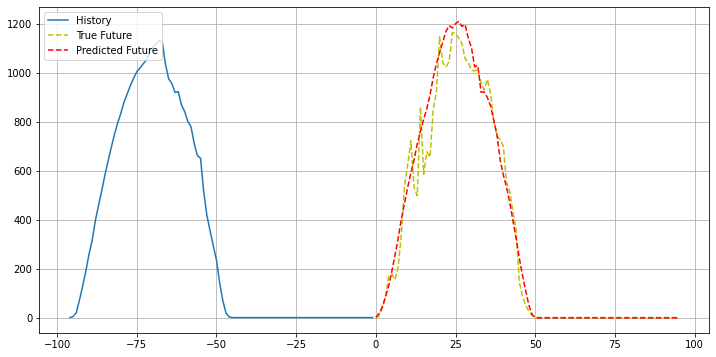

El MAPE para un horizonte de pronostico de 1440 minutos es de: 9.640716027652244 %


In [ ]:
multi_step_plot(xp[0], yhp, pp[0])
print("El MAPE para un horizonte de pronostico de",n*15,"minutos es de:",mae*100,"%")

In [ ]:
tMAE = []
tRMSE = []
for i in range(0,len(y_val),96):
  n=96
  p = predecir(x_train[i], n_pred=n)
  yh = y_train[i:n+i][:,0]
  xp=scalerx.inverse_transform([x_train[i]])
  yhp=scalery.inverse_transform(y_train[i:n+i])
  pp=scalery.inverse_transform([p])
  tMAE.append((abs(yhp-pp)).mean())
  tRMSE.append(((abs(yhp-pp)**2).mean())**0.5)

trainMAE=np.array(tMAE).mean()
trainRMSE=np.array(tRMSE).mean()

vMAE = []
vRMSE = []
for i in range(0,len(y_val),96):
  n=96
  p = predecir(x_val[i], n_pred=n)
  yh = y_val[i:n+i][:,0]
  xp=scalerx.inverse_transform([x_val[i]])
  yhp=scalery.inverse_transform(y_val[i:n+i])
  pp=scalery.inverse_transform([p])
  vMAE.append((abs(yhp-pp)).mean())
  vRMSE.append(((abs(yhp-pp)**2).mean())**0.5)

valMAE=np.array(vMAE).mean()
valRMSE=np.array(vRMSE).mean()

print("-----------------------------------")
print("|  PARA EL SET COMPLETO DE DATOS   |")
print("----------------------------------")
print("|  MAE   |   MAPE[%] |       RMSE  |    <-------- Datos de entrenamiento")
print("----------------------------------")
print("%9.4f%12.4f%12.4f"%(trainMAE,0,trainRMSE))
print("----------------------------------")
print("|  MAE   |   MAPE[%] |       RMSE  |    <-------- Datos de validación")
print("----------------------------------")
print("%9.4f%12.4f%12.4f"%(valMAE,0,valRMSE))
print("----------------------------------")

-----------------------------------
|  PARA EL SET COMPLETO DE DATOS   |
----------------------------------
|  MAE   |   MAPE[%] |       RMSE  |    <-------- Datos de entrenamiento
----------------------------------
 402.5092      0.0000    548.4990
----------------------------------
|  MAE   |   MAPE[%] |       RMSE  |    <-------- Datos de validación
----------------------------------
 415.0164      0.0000    563.1136
----------------------------------


- **Cálculo del error para el dataset completo**

In [ ]:
y_pred1 = model.predict(x_train)
y_pred2 = model.predict(x_val)
y_re1 = scalery.inverse_transform([model.predict(x_train)])
y_re2 = scalery.inverse_transform([model.predict(x_val)])
y_t1 = scalery.inverse_transform(y_train)
y_v2 = scalery.inverse_transform(y_val)

In [ ]:
trainMSE = mean_squared_error(y_t1, y_re1[0])
valMSE = mean_squared_error(y_v2, y_re2[0])
trainMAE = mean_absolute_error(y_t1, y_re1[0])
valMAE = mean_absolute_error(y_v2, y_re2[0])
trainMAPE = mean_absolute_percentage_error(y_train, y_pred1)
valMAPE = mean_absolute_percentage_error(y_v2, y_re2[0])

In [ ]:
print("----------------------------------")
print("|  MAE   |   MAPE[%] |       RMSE  |    <-------- Datos de entrenamiento")
print("----------------------------------")
print("%9.4f%12.4f%12.4f"%(trainMAE,trainMAPE,trainMSE**(1/2)))
print("----------------------------------")
print("|  MAE   |   MAPE[%] |       RMSE  |    <-------- Datos de validación")
print("----------------------------------")
print("%9.4f%12.4f%12.4f"%(valMAE,valMAPE,valMSE**(1/2)))
print("----------------------------------")


----------------------------------
|  MAE   |   MAPE[%] |       RMSE  |    <-------- Datos de entrenamiento
----------------------------------
   6.4571      0.0754      9.5481
----------------------------------
|  MAE   |   MAPE[%] |       RMSE  |    <-------- Datos de validación
----------------------------------
  39.683839241098687454936.0000     79.9286
----------------------------------


In [ ]:

print("---------------------------------------------------")
print("|  Predicted |  Actual   |    MAE   |    MAPE[%]  |")
print("---------------------------------------------------")
for i in range(100,150):
  pr=model.predict(x_val[i:i+1])
  yhat=y_val[i][0]
  print("%11.6f%12.6f%12.6f%12.3f"%(pr,yhat,abs(pr-yhat),abs((pr-yhat))*100/pr))
print("--------------------------------------------------")

---------------------------------------------------
|  Predicted |  Actual   |    MAE   |    MAPE[%]  |
---------------------------------------------------
   1.273071    1.275500    0.002430       0.191
   1.310750    1.387047    0.076297       5.821
   1.441730    1.467878    0.026149       1.814
   1.485363    1.552291    0.066929       4.506
   1.601802    1.624009    0.022207       1.386
   1.659003    1.686831    0.027828       1.677
   1.754764    1.724722    0.030042       1.712
   1.751189    1.766305    0.015115       0.863
   1.854336    1.802473    0.051863       2.797
   1.860152    1.877996    0.017845       0.959
   1.897756    1.933569    0.035813       1.887
   1.970062    1.953157    0.016905       0.858
   1.893138    1.997140    0.104003       5.494
   1.934892    1.981490    0.046598       2.408
   1.988005    1.759256    0.228750      11.506
   1.777825    1.616146    0.161679       9.094
   1.641766    1.571315    0.070451       4.291
   1.551041    1.480845    0